<img src='https://img.rasset.ie/00087d62-800.jpg' width='60%' align='center'>

---
<h1 align='center'>Fannie Mae Mortgage Default</h1>
<h2 align='center'>Predictive Modelling with Machine Learning</h2>
<h3 align='center'>By Jeffery Chu Yun Qiang</h3>

---

# Improvements

Based on file 'Fannie Mae Mortgage Default Prediction Project (Pandas) - V2.7 (Fully Working Original).ipynb'.

1. Binning of all variables
3. Put the list in this for loop outside as a variable as this is hard to read
    for x in [column for column in perf_df.columns if column not in ['rep_year','rep_quarter','rep_period','id',
                                                                 'curr_act_upb','curr_int_rate','loan_age',
                                                                 'remaining_months_legal','adjusted_months_legal',
                                                                 'all_diff_in_months','curr_ltv_diff_perc']]:
4. for dummies, make everything ready till before train/test split, then dummy the whole dataframe. Won't have to dummy each variable separately. The function will leave numeric fields and only convert string columns.
5. Combine all results into one chart

# End - Improvements

---
Continuing from our previous data exploration notebook, we will now begin the data munging and machine learning parts of the project. 

We will use the 2007 Q4 data set to develop default prediction models using various machine learning algorithms. Being a machine learning project, we need to be methodical and go through the following major steps to properly develop a successful model:

### Structure of Project
1. Definition of target labels
2. Data exploration
3. Feature pre-processing and selection
4. Development and training of predictive models
5. Evaluation of models and metrics comparisons
6. Iterate and improve as necessary

### Definition of Default
We will structure this as a binary classification problem and define a mortgage to have defaulted if payment has been missed for 90 days or more. This is based on the [BASEL II definition of loan default](https://www.federalreserve.gov/boarddocs/press/bcreg/2004/20040626/attachment.pdf). Mortgages that fit this criteria will be labelled with '1' while loans that have not defaulted will be labelled with '0'.

### Dataset Tables
The mortgage dataset consists of 2 main tables:
1. Acquisition
2. Performance

In [1]:
# Import all needed modules

import numpy as np
import pandas as pd
import re
import itertools
import missingno as msno
import seaborn as sns
from collections import Counter
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rc, rcParams
%matplotlib inline

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, \
classification_report, roc_auc_score, roc_curve
import xgboost as xgb

# SMOTE
from imblearn.over_sampling import SMOTE

# Set Pandas view options as needed
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [2]:
# Set file and path parameters (update to your own file path before continuing)
path_loc = '/mnt/d/Users/machine_learning_projects/Fannie Mae/2007Q4/'
acq_file_name = 'Acquisition_2007Q4.txt'
perf_file_name = 'Performance_2007Q4.txt'

<h1 align='center'>Features Pre-Processing and Selection</h1>

After data exploration, we can now begin data features pre-processing and selection to get our data into a form that can be ingested for predictive model training and testing.

## Data Cleaning/Munging

In [3]:
# Acquisition File Column and Data Type Definition

acq_cols = ['id_A',
            'orig_channel_A',
            'seller_name_A',
            'orig_int_rate_A',
            'orig_upb_A',
            'orig_loan_term_A',
            'orig_date_A',
            'first_pay_date_A',
            'orig_ltv_A',
            'orig_cltv_A',
            'borrowers_A',
            'orig_dtir_A',
            'borrower_credit_score_A',
            'first_time_buyer_A',
            'purpose_A',
            'property_type_A',
            'num_of_units_A',
            'occupancy_type_A',
            'state_A',
            'zip_A',
            'insurance_perc_A',
            'product_type_A',
            'co_borrower_credit_score_A',
            'insurance_type_A',
            'relocation_A']

acq_dtypes = {'id_A':'int64',
              'orig_channel_A':'object',
              'seller_name_A':'object',
              'orig_int_rate_A':'float64',
              'orig_upb_A':'float64',
              'orig_loan_term_A':'int64',
              'orig_date_A':'object',
              'first_pay_date_A':'object',
              'orig_ltv_A':'float64',
              'orig_cltv_A':'float64',
              'borrowers_A':'float64',
              'orig_dtir_A':'float64',
              'borrower_credit_score_A':'float64',
              'first_time_buyer_A':'object',
              'purpose_A':'object',
              'property_type_A':'object',
              'num_of_units_A':'object',
              'occupancy_type_A':'object',
              'state_A':'object',
              'zip_A':'object',
              'insurance_perc_A':'float64',
              'product_type_A':'object',
              'co_borrower_credit_score_A':'float64',
              'insurance_type_A':'float64',
              'relocation_A':'object'}

# Load Acquisition File
acq_df = pd.read_csv('{path_loc}{file_name}'.format(path_loc=path_loc, file_name=acq_file_name), 
                     sep='|', names=acq_cols, dtype=acq_dtypes)

# Check sample of data
display(acq_df.head(10))

,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,10/2007,12/2007,86.0,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,10/2007,12/2007,62.0,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N
2,100008184591,B,OTHER,6.625,81000.0,360,11/2007,01/2008,64.0,82.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,11/2007,01/2008,71.0,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,10/2007,12/2007,27.0,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N
5,100016840211,R,"PNC BANK, N.A.",6.375,210000.0,360,08/2007,10/2007,80.0,93.0,1.0,42.0,787.0,N,P,SF,1,P,PA,160,NaN,FRM,NaN,NaN,N
6,100023772994,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.750,172000.0,360,09/2007,11/2007,95.0,95.0,1.0,42.0,698.0,N,P,CO,1,P,IL,605,30.0,FRM,NaN,1.0,N
7,100026162343,B,"BANK OF AMERICA, N.A.",6.875,108000.0,360,11/2007,01/2008,90.0,90.0,2.0,51.0,647.0,N,P,SF,2,I,MO,631,25.0,FRM,668.0,1.0,N
8,100030319603,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.250,175000.0,180,10/2007,12/2007,70.0,70.0,1.0,53.0,662.0,N,C,SF,1,P,IL,601,NaN,FRM,NaN,NaN,N
9,100031046995,C,"BANK OF AMERICA, N.A.",6.500,224000.0,360,10/2007,12/2007,62.0,62.0,1.0,50.0,744.0,N,R,PU,1,P,AZ,850,NaN,FRM,NaN,NaN,N


In [4]:
# Performance File Column and Data Type Definition

perf_cols = ['id',
             'rep_period',
             'servicer',
             'curr_int_rate',
             'curr_act_upb',
             'loan_age',
             'remaining_months_legal',
             'adjusted_months_legal',
             'maturity_date',
             'MSA',
             'current_loan_stat',
             'mod_flag',
             'zero_bal_code',
             'zero_bal_date',
             'last_paid_date',
             'foreclosure_date',
             'disposition_date',
             'foreclosure_cost',
             'preservation_costs',
             'recovery_costs',
             'holding_expenses_and_credits',
             'holding_tax',
             'net_sale_proceeds',
             'credit_enhance_proceeds',
             'make_whole_proceeds',
             'other_proceeds',
             'non_int_bearing_upd',
             'principal_forgiveness_amount',
             'make_whole_proceeds_flag',
             'foreclosure_principal_write_off',
             'servicing_activity_indicator']

perf_dtypes = {'id':'int64',
               'rep_period':'object',
               'servicer':'object',
               'curr_int_rate':'float64',
               'curr_act_upb':'float64',
               'loan_age':'int64',
               'remaining_months_legal':'float64',
               'adjusted_months_legal':'float64',
               'maturity_date':'object',
               'MSA':'object',
               'current_loan_stat':'object',
               'mod_flag':'object',
               'zero_bal_code':'object',
               'zero_bal_date':'object',
               'last_paid_date':'object',
               'foreclosure_date':'object',
               'disposition_date':'object',
               'foreclosure_cost':'float64',
               'preservation_costs':'float64',
               'recovery_costs':'float64',
               'holding_expenses_and_credits':'float64',
               'holding_tax':'float64',
               'net_sale_proceeds':'float64',
               'credit_enhance_proceeds':'float64',
               'make_whole_proceeds':'float64',
               'other_proceeds':'float64',
               'non_int_bearing_upd':'float64',
               'principal_forgiveness_amount':'float64',
               'make_whole_proceeds_flag':'object',
               'foreclosure_principal_write_off':'float64',
               'servicing_activity_indicator':'str'}
date_cols = ['rep_period']

# Load Performance File
perf_df = pd.read_csv('{path_loc}{file_name}'.format(path_loc=path_loc, file_name=perf_file_name), sep='|',
                      names=perf_cols, dtype=perf_dtypes, 
                      parse_dates=date_cols)

# Check sample of data
perf_df.head(10)

,id,rep_period,servicer,curr_int_rate,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,maturity_date,MSA,current_loan_stat,mod_flag,zero_bal_code,zero_bal_date,last_paid_date,foreclosure_date,disposition_date,foreclosure_cost,preservation_costs,recovery_costs,holding_expenses_and_credits,holding_tax,net_sale_proceeds,credit_enhance_proceeds,make_whole_proceeds,other_proceeds,non_int_bearing_upd,principal_forgiveness_amount,make_whole_proceeds_flag,foreclosure_principal_write_off,servicing_activity_indicator
0,100002296854,2007-11-01,"BANK OF AMERICA, N.A.",6.625,NaN,0,360.0,359.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002296854,2007-12-01,NaN,6.625,NaN,1,359.0,358.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100002296854,2008-01-01,NaN,6.625,NaN,2,358.0,357.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100002296854,2008-02-01,NaN,6.625,NaN,3,357.0,356.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,100002296854,2008-03-01,NaN,6.625,NaN,4,356.0,355.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
5,100002296854,2008-04-01,NaN,6.625,NaN,5,355.0,354.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
6,100002296854,2008-05-01,NaN,6.625,340846.24,6,354.0,353.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
7,100002296854,2008-06-01,NaN,6.625,340846.24,7,353.0,353.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,100002296854,2008-07-01,NaN,6.625,340215.48,8,352.0,351.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
9,100002296854,2008-08-01,NaN,6.625,339897.48,9,351.0,350.0,11/2037,17820,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [5]:
# Drop columns that have values populated after a default event and those with high missing values
def_cols = ['non_int_bearing_upd',              # After default
            'principal_forgiveness_amount',     # After default
            'zero_bal_date',                    # After default
            'last_paid_date',                   # After default
            'foreclosure_date',                 # After default
            'disposition_date',                 # After default
            'foreclosure_cost',                 # After default
            'preservation_costs',               # After default
            'recovery_costs',                   # After default
            'holding_expenses_and_credits',     # After default
            'holding_tax',                      # After default
            'net_sale_proceeds',                # After default
            'credit_enhance_proceeds',          # After default
            'make_whole_proceeds',              # After default
            'other_proceeds',                   # After default  
            'make_whole_proceeds_flag',         # After default
            'foreclosure_principal_write_off',  # After default
            'servicer',                         # Majority is empty
            'maturity_date']                    # Not needed

# Load Performance File
perf_df = perf_df.drop(columns=def_cols)

#####################################
# For testing only (Remove when done)
#####################################
perf_df = perf_df.sample(frac=0.1)
#####################################

In [6]:
perf_df.head()

,id,rep_period,curr_int_rate,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator
11708399,611291701434,2014-04-01,7.000,59405.11,76,284.0,271.0,26420,0,N,NaN,N
8488582,471387577904,2009-04-01,5.875,104864.40,17,343.0,343.0,41700,0,N,NaN,N
5600821,344536895277,2010-02-01,6.200,111942.62,26,334.0,334.0,45300,0,N,NaN,N
13962504,710298065465,2018-03-01,6.125,54223.50,123,237.0,237.0,41420,0,N,NaN,N
11303019,593586148840,2013-07-01,7.125,58734.37,68,292.0,292.0,26900,0,N,NaN,N


In [7]:
print('The dimensions of the acquisition dataframe are: {}'.format(acq_df.shape))
print('The dimensions of the performance dataframe are: {}'.format(perf_df.shape))

The dimensions of the acquisition dataframe are: (391209, 25)
The dimensions of the performance dataframe are: (2061862, 12)


In [8]:
# Filter out those rows that have 'current_loan_stat' as null or X
perf_df = perf_df[(perf_df['current_loan_stat'].notnull()) & (perf_df['current_loan_stat'] != 'X')]

# Define the conversion function for the target labels based on our initial definition (Basel II)
perf_df['current_loan_stat'] = (perf_df['current_loan_stat'].isin(['0','1','2'])
                                .map({True:0, False:1}))

# Filter out information after a loan's delinquency as in real-case, we only have data before delinquency
# To do this, we first calculate cumulative sum of 'current_loan_stat'
# Then, we filter to take only those at or before the first delinquency
perf_df['cum_loan_stat'] = perf_df.groupby('id')['current_loan_stat'].cumsum()
perf_df = perf_df[perf_df['cum_loan_stat'] <= 1]

print(perf_df['id'].count())
perf_df.head()

1872273


,id,rep_period,curr_int_rate,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat
11708399,611291701434,2014-04-01,7.000,59405.11,76,284.0,271.0,26420,0,N,NaN,N,0
8488582,471387577904,2009-04-01,5.875,104864.40,17,343.0,343.0,41700,0,N,NaN,N,0
5600821,344536895277,2010-02-01,6.200,111942.62,26,334.0,334.0,45300,0,N,NaN,N,0
13962504,710298065465,2018-03-01,6.125,54223.50,123,237.0,237.0,41420,0,N,NaN,N,0
11303019,593586148840,2013-07-01,7.125,58734.37,68,292.0,292.0,26900,0,N,NaN,N,0


In [9]:
perf_df.dtypes

id                                       int64
rep_period                      datetime64[ns]
curr_int_rate                          float64
curr_act_upb                           float64
loan_age                                 int64
remaining_months_legal                 float64
adjusted_months_legal                  float64
MSA                                     object
current_loan_stat                        int64
mod_flag                                object
zero_bal_code                           object
servicing_activity_indicator            object
cum_loan_stat                            int64
dtype: object

In [10]:
# # Convert rep_period to date format (actual format mm/dd/YYYY)
# perf_df['rep_period'] = pd.to_datetime(perf_df['rep_period'],format='%Y-%m-%d')

# Function to determine quarter

def quarter_func(x):
    if x.month in [1,2,3]:
        return 1
    elif x.month in [4,5,6]:
        return 2
    elif x.month in [7,8,9]:
        return 3
    else:
        return 4

# Create quarter and year column from 'rep_period'
perf_df.insert(3, 'rep_quarter', perf_df['rep_period'].apply(quarter_func))
perf_df.insert(2, 'rep_year', perf_df['rep_period'].apply(lambda x: x.year))

In [11]:
perf_df.head()

,id,rep_period,rep_year,curr_int_rate,rep_quarter,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat
11708399,611291701434,2014-04-01,2014,7.000,2,59405.11,76,284.0,271.0,26420,0,N,NaN,N,0
8488582,471387577904,2009-04-01,2009,5.875,2,104864.40,17,343.0,343.0,41700,0,N,NaN,N,0
5600821,344536895277,2010-02-01,2010,6.200,1,111942.62,26,334.0,334.0,45300,0,N,NaN,N,0
13962504,710298065465,2018-03-01,2018,6.125,1,54223.50,123,237.0,237.0,41420,0,N,NaN,N,0
11303019,593586148840,2013-07-01,2013,7.125,3,58734.37,68,292.0,292.0,26900,0,N,NaN,N,0


### Calculation of Custom Features using Original and External Data

The LTV (Loan-to-Value Ratio) at origination theoratically would be an important feature for default prediction; we will augment this by including external house pricing indices from the FHFA [(Federal Housing Finance Agency)](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo). 

The idea here is that we want to observe what happens as house prices change over the years of the loan, in relation to the origination loan amounts. In theory, falling house prices will mean higher LTVs, which will likely result in higher default rates as borrowers deem their investments unfeasible to continue paying for. We will thus create a calculated field called **'max_curr_ltv_diff_perc'** that will give the highest LTV a mortgage has experienced over its lifetime. This will be used as a supplementary feature in our predictive models to improve performance.

We will also create another calculated feature called **'diff_in_months'**. This feature will keep track of a loan's payment history before a default event. It is the difference between the 'adjusted_months_legal' and 'remaining_months_legal' fields. If a borrower makes early payments, the 'adjusted_months_legal' field will have a lower value than the 'remaining_months_legal' field, thereby giving a negative value. If a borrower misses a payment, this will become positive. 

The performance table has the 'MSA' field so let's see if we can merge it with the FHFA's metro table, which corresponds to the 'MSA' field. We will first load the FHFA data that corresponds to the MSA field.

In [12]:
fhfa_df = pd.read_excel('/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_metro.xls')
fhfa_df.head()

,cbsa,metro_name,yr,qtr,index_nsa,index_sa
0,10420,"Akron, OH",1991,1,100.00,100.00
1,10420,"Akron, OH",1991,2,102.45,101.19
2,10420,"Akron, OH",1991,3,101.96,101.39
3,10420,"Akron, OH",1991,4,103.03,103.07
4,10420,"Akron, OH",1992,1,104.53,104.53


Let's see if all the MSA match up with the codes in FHFA data from above.

In [13]:
fhfa_df = fhfa_df.drop(columns=['metro_name','index_nsa'])

In [14]:
fhfa_df.head()

,cbsa,yr,qtr,index_sa
0,10420,1991,1,100.00
1,10420,1991,2,101.19
2,10420,1991,3,101.39
3,10420,1991,4,103.07
4,10420,1992,1,104.53


In [15]:
# List of MSA in perf_df
perf_msa = perf_df['MSA'].unique().tolist()
print('Number of unique MSA codes in perf_df:', len(perf_msa))

# List of MSA in fhfa_df
fhfa_msa = [str(x) for x in fhfa_df['cbsa'].unique().tolist()]
print('Number of unique MSA codes in FHFA metro file:', len(fhfa_msa))

# Intersection of both lists
msa_int = set(fhfa_msa).intersection(set(perf_msa))
print('Number of intersecting MSA:', len(msa_int))

Number of unique MSA codes in perf_df: 406
Number of unique MSA codes in FHFA metro file: 100
Number of intersecting MSA: 72


Not all the MSA codes are intersecting. This means we will need to use another location field that can match to housing indices. The FHFA provides state-level housing indices as well. This will be used to fill housing index values when the MSA values are unavailable. For now, let's join the metro dataframe with the performance dataframe. To do so, we need to convert the 'cbsa' field in 'fhfa_df' to string type first given values such as '00000' that may be truncated in numeric types. 

In [16]:
fhfa_df['cbsa'] = fhfa_df['cbsa'].astype(str)

In [17]:
fhfa_df.head()

,cbsa,yr,qtr,index_sa
0,10420,1991,1,100.00
1,10420,1991,2,101.19
2,10420,1991,3,101.39
3,10420,1991,4,103.07
4,10420,1992,1,104.53


In [18]:
perf_df.head()

,id,rep_period,rep_year,curr_int_rate,rep_quarter,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat
11708399,611291701434,2014-04-01,2014,7.000,2,59405.11,76,284.0,271.0,26420,0,N,NaN,N,0
8488582,471387577904,2009-04-01,2009,5.875,2,104864.40,17,343.0,343.0,41700,0,N,NaN,N,0
5600821,344536895277,2010-02-01,2010,6.200,1,111942.62,26,334.0,334.0,45300,0,N,NaN,N,0
13962504,710298065465,2018-03-01,2018,6.125,1,54223.50,123,237.0,237.0,41420,0,N,NaN,N,0
11303019,593586148840,2013-07-01,2013,7.125,3,58734.37,68,292.0,292.0,26900,0,N,NaN,N,0


In [19]:
perf_df = pd.merge(perf_df, fhfa_df, 
                   left_on=['MSA','rep_year','rep_quarter'],
                   right_on=['cbsa','yr','qtr'], how='left').drop(columns=['cbsa','yr','qtr'])
perf_df.head()

,id,rep_period,rep_year,curr_int_rate,rep_quarter,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa
0,611291701434,2014-04-01,2014,7.000,2,59405.11,76,284.0,271.0,26420,0,N,NaN,N,0,255.82
1,471387577904,2009-04-01,2009,5.875,2,104864.40,17,343.0,343.0,41700,0,N,NaN,N,0,205.17
2,344536895277,2010-02-01,2010,6.200,1,111942.62,26,334.0,334.0,45300,0,N,NaN,N,0,194.37
3,710298065465,2018-03-01,2018,6.125,1,54223.50,123,237.0,237.0,41420,0,N,NaN,N,0,NaN
4,593586148840,2013-07-01,2013,7.125,3,58734.37,68,292.0,292.0,26900,0,N,NaN,N,0,163.70


Now let's load the state-level housing indices' FHFA file into a dataframe. The source is from the same link at [FHFA's House Price Index Repository](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo).

In [20]:
fhfa_state_df = (pd.read_excel('/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_state.xls')
                 .drop(columns=['index_nsa','Warning']))
fhfa_state_df.head()

,state,yr,qtr,index_sa
0,AK,1991,1,100.00
1,AK,1991,2,99.97
2,AK,1991,3,101.04
3,AK,1991,4,102.04
4,AK,1992,1,102.23


The following two cells calculate the initial stages of the two custom features **'max_curr_ltv_diff_perc'** and **'diff_in_months'**.

In [21]:
# Calculate difference in adjusted and remaining months to see if any pre-payment done
perf_df['all_diff_in_months'] = (perf_df['adjusted_months_legal'] - perf_df['remaining_months_legal'])

In [22]:
perf_df.head()

,id,rep_period,rep_year,curr_int_rate,rep_quarter,curr_act_upb,loan_age,remaining_months_legal,adjusted_months_legal,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa,all_diff_in_months
0,611291701434,2014-04-01,2014,7.000,2,59405.11,76,284.0,271.0,26420,0,N,NaN,N,0,255.82,-13.0
1,471387577904,2009-04-01,2009,5.875,2,104864.40,17,343.0,343.0,41700,0,N,NaN,N,0,205.17,0.0
2,344536895277,2010-02-01,2010,6.200,1,111942.62,26,334.0,334.0,45300,0,N,NaN,N,0,194.37,0.0
3,710298065465,2018-03-01,2018,6.125,1,54223.50,123,237.0,237.0,41420,0,N,NaN,N,0,NaN,0.0
4,593586148840,2013-07-01,2013,7.125,3,58734.37,68,292.0,292.0,26900,0,N,NaN,N,0,163.70,0.0


In [23]:
# Fill Nan with 0
perf_df['all_diff_months'] = perf_df['all_diff_in_months'].fillna(0)

In [24]:
# Merge state from acquisition with performance data
perf_df = (pd.merge(perf_df, acq_df[['id_A','state_A', 'orig_ltv_A']], 
                    left_on=['id'],right_on=['id_A'], how='inner')
           .drop(columns=['id_A','adjusted_months_legal','remaining_months_legal',
                          'rep_period','curr_act_upb']))

In [25]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa,all_diff_in_months,all_diff_months,state_A,orig_ltv_A
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,205.25,-8.0,-8.0,TX,90.0
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,198.10,-6.0,-6.0,TX,90.0
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,200.95,-7.0,-7.0,TX,90.0
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0


In [26]:
# Now to join with FHFA file (State) on state, year and quarter to get 'index_sa'
perf_df = pd.merge(perf_df, fhfa_state_df, 
                   left_on=['state_A','rep_year','rep_quarter'], 
                   right_on=['state','yr','qtr'], how='left')

In [27]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa_x,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,state,yr,qtr,index_sa_y
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0,TX,2014.0,2.0,217.62
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,205.25,-8.0,-8.0,TX,90.0,TX,2012.0,1.0,189.04
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,198.10,-6.0,-6.0,TX,90.0,TX,2011.0,3.0,185.17
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,200.95,-7.0,-7.0,TX,90.0,TX,2011.0,4.0,186.80
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0,TX,2014.0,2.0,217.62


In [28]:
# List comprehension to get value from index_sa_x, but if nan, get from index_sa_y
perf_df['index_sa'] = [a if ~np.isnan(a) else b for a, b in zip(perf_df['index_sa_x'], perf_df['index_sa_y'])]

In [29]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,index_sa_x,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,state,yr,qtr,index_sa_y,index_sa
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0,TX,2014.0,2.0,217.62,255.82
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,205.25,-8.0,-8.0,TX,90.0,TX,2012.0,1.0,189.04,205.25
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,198.10,-6.0,-6.0,TX,90.0,TX,2011.0,3.0,185.17,198.10
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,200.95,-7.0,-7.0,TX,90.0,TX,2011.0,4.0,186.80,200.95
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,255.82,-13.0,-13.0,TX,90.0,TX,2014.0,2.0,217.62,255.82


In [30]:
perf_df = perf_df.drop(columns=['index_sa_x', 'index_sa_y', 'yr', 'qtr', 'state'])

In [31]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82


In [32]:
# Determine percentage change in housing index using window function
perf_df['loan_group_diff'] = (perf_df
                              .sort_values(['loan_age'], ascending=True)
                              .groupby('id')['index_sa']
                              .pct_change(periods=1, fill_method='pad'))

In [33]:
# Check example
perf_df[perf_df['id']==275817005784]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff
1227743,275817005784,2014,2.000,2,80,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,298.55,0.014096
1227744,275817005784,2012,2.000,3,57,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,258.52,0.058424
1227745,275817005784,2014,2.000,1,76,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,294.40,0.138790
1227746,275817005784,2011,2.000,4,50,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,245.33,-0.007725
1227747,275817005784,2011,2.000,1,40,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,247.24,-0.238465
1227748,275817005784,2012,2.000,1,51,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,244.25,-0.004402
1227749,275817005784,2016,4.000,2,103,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,362.68,0.191654
1227750,275817005784,2017,5.000,4,120,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,406.81,0.121678
1227751,275817005784,2014,2.000,3,82,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,304.35,0.019427
1227752,275817005784,2008,5.875,1,5,00000,0,N,NaN,N,0,0.0,0.0,OR,64.0,324.66,NaN


In [34]:
(258.52-285.12)/285.12

-0.09329405162738504

In [35]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.016369
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25,0.021398
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10,-0.021293
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95,0.014387
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.000000


In [36]:
# Fill NA in 'loan_group_diff' with 1 as the base house index for each id
perf_df['loan_group_diff'] = perf_df['loan_group_diff'].fillna(1)

In [37]:
# Check example
perf_df[perf_df['id']==275817005784]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff
1227743,275817005784,2014,2.000,2,80,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,298.55,0.014096
1227744,275817005784,2012,2.000,3,57,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,258.52,0.058424
1227745,275817005784,2014,2.000,1,76,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,294.40,0.138790
1227746,275817005784,2011,2.000,4,50,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,245.33,-0.007725
1227747,275817005784,2011,2.000,1,40,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,247.24,-0.238465
1227748,275817005784,2012,2.000,1,51,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,244.25,-0.004402
1227749,275817005784,2016,4.000,2,103,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,362.68,0.191654
1227750,275817005784,2017,5.000,4,120,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,406.81,0.121678
1227751,275817005784,2014,2.000,3,82,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,304.35,0.019427
1227752,275817005784,2008,5.875,1,5,00000,0,N,NaN,N,0,0.0,0.0,OR,64.0,324.66,1.000000


In [38]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.016369
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25,0.021398
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10,-0.021293
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95,0.014387
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.000000


In [39]:
# Calculate cumulative sum of 'loan_group_diff'
perf_df['cum_index'] = (perf_df
                        .sort_values(['loan_age'], ascending=True)
                        .groupby('id')['loan_group_diff'].cumsum())

In [40]:
# Check example
perf_df[perf_df['id']==275817005784]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index
1227743,275817005784,2014,2.000,2,80,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,298.55,0.014096,0.960718
1227744,275817005784,2012,2.000,3,57,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,258.52,0.058424,0.807831
1227745,275817005784,2014,2.000,1,76,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,294.40,0.138790,0.946621
1227746,275817005784,2011,2.000,4,50,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,245.33,-0.007725,0.753810
1227747,275817005784,2011,2.000,1,40,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,247.24,-0.238465,0.761535
1227748,275817005784,2012,2.000,1,51,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,244.25,-0.004402,0.749408
1227749,275817005784,2016,4.000,2,103,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,362.68,0.191654,1.171799
1227750,275817005784,2017,5.000,4,120,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,406.81,0.121678,1.293477
1227751,275817005784,2014,2.000,3,82,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,304.35,0.019427,0.980145
1227752,275817005784,2008,5.875,1,5,00000,0,N,NaN,N,0,0.0,0.0,OR,64.0,324.66,1.000000,1.000000


In [41]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.016369,1.270349
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25,0.021398,1.044946
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10,-0.021293,1.009161
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95,0.014387,1.023548
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.000000,1.270349


In [42]:
# Calculate current ltv
perf_df['curr_ltv'] = perf_df['orig_ltv_A']/perf_df['cum_index']

In [43]:
# Check example
perf_df[perf_df['id']==275817005784]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index,curr_ltv
1227743,275817005784,2014,2.000,2,80,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,298.55,0.014096,0.960718,66.616852
1227744,275817005784,2012,2.000,3,57,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,258.52,0.058424,0.807831,79.224455
1227745,275817005784,2014,2.000,1,76,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,294.40,0.138790,0.946621,67.608866
1227746,275817005784,2011,2.000,4,50,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,245.33,-0.007725,0.753810,84.902047
1227747,275817005784,2011,2.000,1,40,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,247.24,-0.238465,0.761535,84.040770
1227748,275817005784,2012,2.000,1,51,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,244.25,-0.004402,0.749408,85.400786
1227749,275817005784,2016,4.000,2,103,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,362.68,0.191654,1.171799,54.616854
1227750,275817005784,2017,5.000,4,120,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,406.81,0.121678,1.293477,49.479041
1227751,275817005784,2014,2.000,3,82,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,304.35,0.019427,0.980145,65.296454
1227752,275817005784,2008,5.875,1,5,00000,0,N,NaN,N,0,0.0,0.0,OR,64.0,324.66,1.000000,1.000000,64.000000


In [44]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index,curr_ltv
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.016369,1.270349,70.846686
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25,0.021398,1.044946,86.128821
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10,-0.021293,1.009161,89.182963
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95,0.014387,1.023548,87.929435
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.000000,1.270349,70.846686


In [45]:
# Calculate percentage difference in current ltv from original ltv
perf_df['curr_ltv_diff_perc'] = (perf_df['curr_ltv'] - perf_df['orig_ltv_A'])*100/perf_df['orig_ltv_A']

In [46]:
# Check example
perf_df[perf_df['id']==275817005784]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index,curr_ltv,curr_ltv_diff_perc
1227743,275817005784,2014,2.000,2,80,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,298.55,0.014096,0.960718,66.616852,4.088831
1227744,275817005784,2012,2.000,3,57,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,258.52,0.058424,0.807831,79.224455,23.788211
1227745,275817005784,2014,2.000,1,76,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,294.40,0.138790,0.946621,67.608866,5.638854
1227746,275817005784,2011,2.000,4,50,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,245.33,-0.007725,0.753810,84.902047,32.659449
1227747,275817005784,2011,2.000,1,40,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,247.24,-0.238465,0.761535,84.040770,31.313703
1227748,275817005784,2012,2.000,1,51,00000,0,Y,NaN,N,0,NaN,0.0,OR,64.0,244.25,-0.004402,0.749408,85.400786,33.438728
1227749,275817005784,2016,4.000,2,103,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,362.68,0.191654,1.171799,54.616854,-14.661165
1227750,275817005784,2017,5.000,4,120,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,406.81,0.121678,1.293477,49.479041,-22.688998
1227751,275817005784,2014,2.000,3,82,24420,0,Y,NaN,N,0,NaN,0.0,OR,64.0,304.35,0.019427,0.980145,65.296454,2.025710
1227752,275817005784,2008,5.875,1,5,00000,0,N,NaN,N,0,0.0,0.0,OR,64.0,324.66,1.000000,1.000000,64.000000,0.000000


In [47]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,state_A,orig_ltv_A,index_sa,loan_group_diff,cum_index,curr_ltv,curr_ltv_diff_perc
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.016369,1.270349,70.846686,-21.281460
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,TX,90.0,205.25,0.021398,1.044946,86.128821,-4.301310
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,TX,90.0,198.10,-0.021293,1.009161,89.182963,-0.907819
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,TX,90.0,200.95,0.014387,1.023548,87.929435,-2.300628
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,TX,90.0,255.82,0.000000,1.270349,70.846686,-21.281460


In [48]:
# This is how final perf_df should look like before joining with acq_df
perf_df = perf_df.drop(columns=['state_A', 'orig_ltv_A', 'loan_group_diff', 'cum_index', 'index_sa', 'curr_ltv'])

In [49]:
perf_df.head()

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,curr_ltv_diff_perc
0,611291701434,2014,7.0,2,76,26420,0,N,NaN,N,0,-13.0,-13.0,-21.281460
1,611291701434,2012,7.0,1,51,26420,0,N,NaN,N,0,-8.0,-8.0,-4.301310
2,611291701434,2011,7.0,3,44,26420,0,N,NaN,N,0,-6.0,-6.0,-0.907819
3,611291701434,2011,7.0,4,47,26420,0,N,NaN,N,0,-7.0,-7.0,-2.300628
4,611291701434,2014,7.0,2,77,26420,0,N,NaN,N,0,-13.0,-13.0,-21.281460


In [50]:
perf_df[perf_df['id']==100002296854]

,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,mod_flag,zero_bal_code,servicing_activity_indicator,cum_loan_stat,all_diff_in_months,all_diff_months,curr_ltv_diff_perc
1854418,100002296854,2008,6.625,1,4,17820,0,N,NaN,N,0,-1.0,-1.0,0.0


In [51]:
# Check all uniques in dataframe
for x in [column for column in perf_df.columns if column not in ['rep_year','rep_quarter','rep_period','id',
                                                                 'curr_act_upb','curr_int_rate','loan_age',
                                                                 'remaining_months_legal','adjusted_months_legal',
                                                                 'all_diff_in_months','curr_ltv_diff_perc']]:
    print(x,':',perf_df[x].unique())

MSA : ['26420' '41700' '45300' '41420' '26900' '35620' '26100' '26140' '28140'
 '10580' '19100' '37980' '41620' '33100' '30140' '13140' '23420' '38060'
 '00000' '12580' '36740' '19500' '19380' '10420' '33460' '36260' '29460'
 '19460' '17140' '26820' '16980' '10500' '30700' '46060' '12060' '40900'
 '44700' '31340' '26180' '24540' '38340' '14460' '47580' '29820' '19740'
 '20020' '31700' '41740' '48140' '47260' '29540' '47900' '25540' '16740'
 '45820' '42660' '39100' '39300' '13460' '41180' '13820' '33660' '40420'
 '15180' '46140' '18880' '38860' '32820' '31100' '40140' '29340' '37900'
 '20500' '41940' '30780' '18700' '41060' '30860' '39660' '36420' '34980'
 '49180' '25420' '23580' '31080' '39580' '11460' '38900' '15380' '24860'
 '49660' '49340' '19820' '34060' '18140' '33860' '12700' '12620' '31140'
 '45780' '41980' '13780' '39820' '27980' '19300' '37860' '22500' '33340'
 '14260' '40060' '16820' '29180' '17900' '48900' '20100' '14860' '14740'
 '28940' '17820' '46540' '21340' '35380' '383

**Categorical Variables**

We have some interesting categorical variables in the performance table so we will one-hot encode them to transform them to numeric data representative of the categories. This is done using the pandas method of 'get_dummies' as shown below. 

In [52]:
# Dummy variables for 'mod_flag'

n = pd.get_dummies(perf_df['mod_flag'], drop_first=True, prefix='mod_flag')
o = pd.get_dummies(perf_df['servicing_activity_indicator'], drop_first=True, prefix='servicing_activity_indicator',
                   dummy_na=True)
display(n.head())

# Join all after one-hot encoding
perf_df = (pd.concat([perf_df, n, o], axis=1)
           .drop(columns=['mod_flag','servicing_activity_indicator']))
display(perf_df.head())

,mod_flag_Y
0,0
1,0
2,0
3,0
4,0


,id,rep_year,curr_int_rate,rep_quarter,loan_age,MSA,current_loan_stat,zero_bal_code,cum_loan_stat,all_diff_in_months,all_diff_months,curr_ltv_diff_perc,mod_flag_Y,servicing_activity_indicator_Y,servicing_activity_indicator_nan
0,611291701434,2014,7.0,2,76,26420,0,NaN,0,-13.0,-13.0,-21.281460,0,0,0
1,611291701434,2012,7.0,1,51,26420,0,NaN,0,-8.0,-8.0,-4.301310,0,0,0
2,611291701434,2011,7.0,3,44,26420,0,NaN,0,-6.0,-6.0,-0.907819,0,0,0
3,611291701434,2011,7.0,4,47,26420,0,NaN,0,-7.0,-7.0,-2.300628,0,0,0
4,611291701434,2014,7.0,2,77,26420,0,NaN,0,-13.0,-13.0,-21.281460,0,0,0


Now we group the data by loan ID and aggregate to get our custom features **'max_curr_ltv_diff_perc'** and **'diff_in_months'** along with other aggregated features.

In [53]:
perf_df = (perf_df.groupby('id').agg({'curr_int_rate':['mean','max'],
                                      'loan_age':'mean',
                                      'MSA':'max',
                                      'current_loan_stat':['max'],
                                      'all_diff_in_months':'mean',
                                      'curr_ltv_diff_perc':'max',
                                      'mod_flag_Y':'max',
                                      'servicing_activity_indicator_Y':'max'}))

perf_df.columns = ['mean_curr_int_rate',
                   'max_curr_int_rate',
                   'mean_loan_age','MSA',
                   'max_loan_stat',
                   'diff_in_months',
                   'max_curr_ltv_diff_perc',
                   'mod_flag_Y',
                   'max_servicing_activity_indicator']
perf_df.head()

,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,MSA,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator
id,,,,,,,,,
100002296854,6.625000,6.625,4.000000,17820,0,-1.000000,0.000000,0,0
100006876815,6.250000,6.250,40.500000,41740,0,-0.166667,7.756000,0,0
100008184591,5.750000,6.625,52.846154,12940,1,0.500000,5.439761,1,0
100008870761,6.500000,6.500,44.615385,16980,0,-3.153846,26.292578,0,0
100013284158,5.267857,6.625,50.571429,31100,1,0.666667,6.749617,1,0


Given the high cardinality of the MSA field and its disordered nature, we map each category in the MSA field to the mean default rate for that particular category. This will transform it to numeric form while preserving its information value. It is similar to 'Leave-One-Out Encoding'.

In [54]:
(perf_df[perf_df['max_loan_stat'] == 1]
 .groupby('MSA')['max_loan_stat'].count()*100/len(perf_df))

MSA
00000    1.123210
10180    0.001134
10380    0.002551
10420    0.021540
10500    0.002834
           ...   
49420    0.002551
49620    0.020123
49660    0.022391
49700    0.009636
49740    0.012471
Name: max_loan_stat, Length: 400, dtype: float64

In [55]:
(perf_df[perf_df['max_loan_stat'] == 1]
 .groupby('MSA')['max_loan_stat'].count()*100/len(perf_df)).to_dict()

{'00000': 1.1232101760631243,
 '10180': 0.0011336968721303298,
 '10380': 0.002550817962293242,
 '10420': 0.021540240570476266,
 '10500': 0.0028342421803258244,
 '10540': 0.0048182117065539015,
 '10580': 0.03146008820161665,
 '10740': 0.060936206877005225,
 '10780': 0.0036845148344235717,
 '10900': 0.044781026449148026,
 '11020': 0.0017005453081954947,
 '11100': 0.0036845148344235717,
 '11260': 0.00821930232294489,
 '11300': 0.00028342421803258244,
 '11340': 0.0005668484360651649,
 '11460': 0.01048669606720555,
 '11500': 0.001983969526228077,
 '11540': 0.005101635924586484,
 '11640': 0.0005668484360651649,
 '11700': 0.01728887729998753,
 '12020': 0.004251363270488737,
 '12060': 0.29277721722765765,
 '12100': 0.033160633509812146,
 '12220': 0.005951908578684231,
 '12260': 0.011336968721303298,
 '12420': 0.03911254208849638,
 '12540': 0.07369029668847143,
 '12580': 0.2210708900654143,
 '12620': 0.007935878104912308,
 '12700': 0.014454635119661705,
 '12940': 0.024657906968834672,
 '12980':

In [56]:
MSA_map = (perf_df[perf_df['max_loan_stat'] == 1]
           .groupby('MSA')['max_loan_stat'].count()*100)/len(perf_df)

perf_df['MSA_mapped'] = perf_df['MSA'].map(MSA_map.to_dict())
perf_df.head()

,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,MSA,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped
id,,,,,,,,,,
100002296854,6.625000,6.625,4.000000,17820,0,-1.000000,0.000000,0,0,0.018139
100006876815,6.250000,6.250,40.500000,41740,0,-0.166667,7.756000,0,0,0.070289
100008184591,5.750000,6.625,52.846154,12940,1,0.500000,5.439761,1,0,0.024658
100008870761,6.500000,6.500,44.615385,16980,0,-3.153846,26.292578,0,0,0.827599
100013284158,5.267857,6.625,50.571429,31100,1,0.666667,6.749617,1,0,0.340109


In [57]:
perf_df = perf_df.drop(columns=['MSA'])

In [58]:
# Merge the obtained perf_df back into acq_df to get a 'per-id' features snapshot
snapshot_df = pd.merge(acq_df, perf_df, 
                       left_on='id_A', right_index=True, how='inner')
print(snapshot_df.shape)
display(snapshot_df.head())

(352828, 34)


,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,10/2007,12/2007,86.0,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N,6.625000,6.625,4.000000,0,-1.000000,0.000000,0,0,0.018139
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,10/2007,12/2007,62.0,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N,6.250000,6.250,40.500000,0,-0.166667,7.756000,0,0,0.070289
2,100008184591,B,OTHER,6.625,81000.0,360,11/2007,01/2008,64.0,82.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N,5.750000,6.625,52.846154,1,0.500000,5.439761,1,0,0.024658
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,11/2007,01/2008,71.0,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N,6.500000,6.500,44.615385,0,-3.153846,26.292578,0,0,0.827599
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,10/2007,12/2007,27.0,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N,5.267857,6.625,50.571429,1,0.666667,6.749617,1,0,0.340109


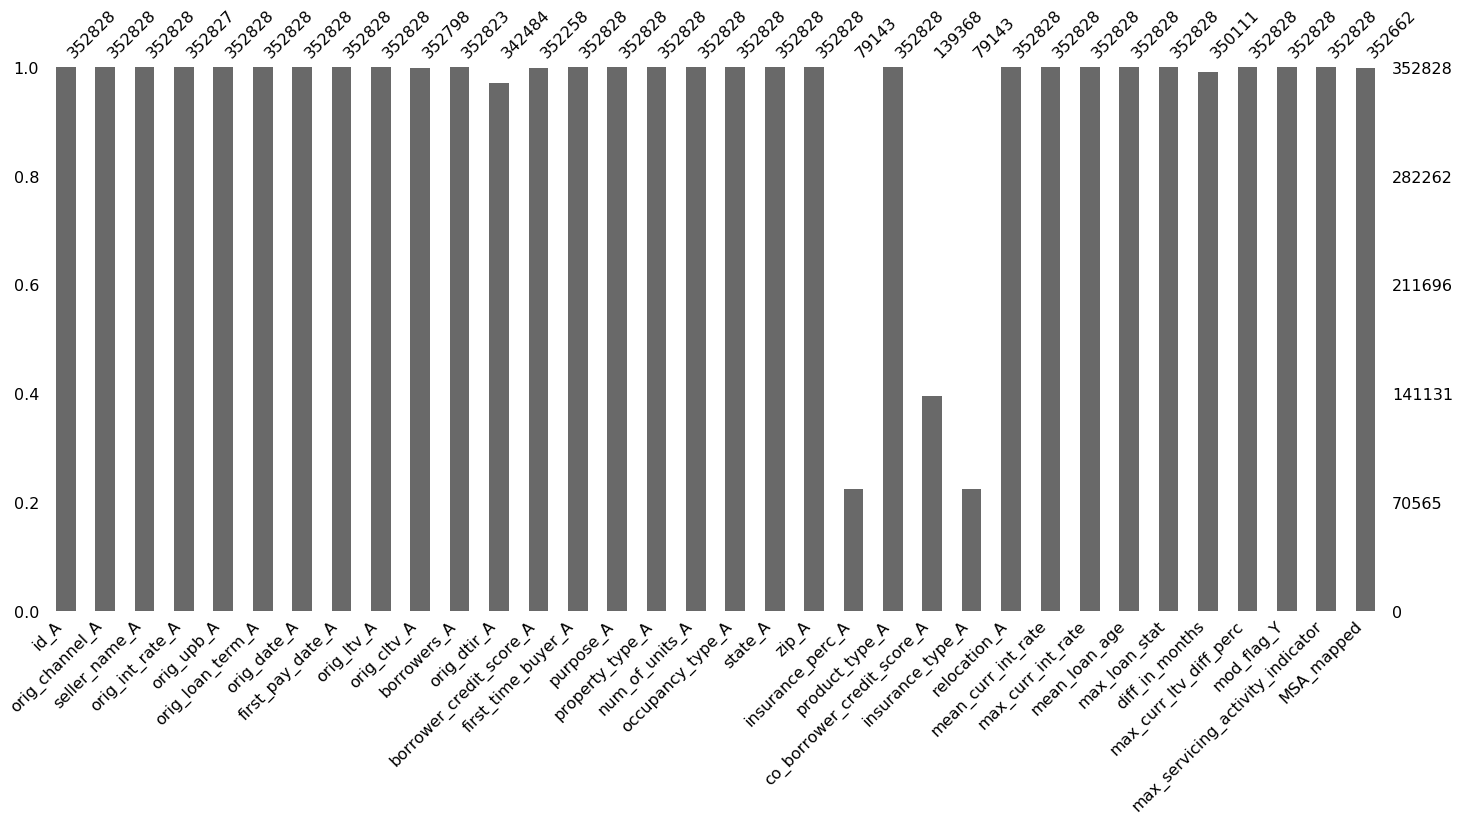

In [59]:
# Plot bar chart of missing data in joined table
msno.bar(snapshot_df)

In [60]:
snapshot_df.head()

,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,10/2007,12/2007,86.0,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N,6.625000,6.625,4.000000,0,-1.000000,0.000000,0,0,0.018139
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,10/2007,12/2007,62.0,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N,6.250000,6.250,40.500000,0,-0.166667,7.756000,0,0,0.070289
2,100008184591,B,OTHER,6.625,81000.0,360,11/2007,01/2008,64.0,82.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N,5.750000,6.625,52.846154,1,0.500000,5.439761,1,0,0.024658
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,11/2007,01/2008,71.0,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N,6.500000,6.500,44.615385,0,-3.153846,26.292578,0,0,0.827599
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,10/2007,12/2007,27.0,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N,5.267857,6.625,50.571429,1,0.666667,6.749617,1,0,0.340109


In [61]:
# Drop columns from snapshot_df (dates and those with lots of nulls)
snapshot_df = snapshot_df.drop(columns=['orig_date_A',                # Date
                                        'first_pay_date_A',           # Date
                                        'orig_cltv_A',                # 99% empty
                                        'insurance_perc_A',           # 78% empty
                                        'co_borrower_credit_score_A', # 60% empty
                                        'product_type_A'])            # only 'FRM' product

In [62]:
snapshot_df.head()

,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_type_A,relocation_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000.0,360,86.0,2.0,27.0,751.0,N,C,PU,1,P,CO,809,2.0,N,6.625000,6.625,4.000000,0,-1.000000,0.000000,0,0,0.018139
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000.0,360,62.0,2.0,35.0,804.0,N,P,SF,1,P,CA,920,NaN,N,6.250000,6.250,40.500000,0,-0.166667,7.756000,0,0,0.070289
2,100008184591,B,OTHER,6.625,81000.0,360,64.0,1.0,53.0,585.0,N,R,SF,1,P,LA,708,NaN,N,5.750000,6.625,52.846154,1,0.500000,5.439761,1,0,0.024658
3,100008870761,B,AMTRUST BANK,6.500,119000.0,360,71.0,1.0,35.0,646.0,N,R,CO,1,P,IL,600,NaN,N,6.500000,6.500,44.615385,0,-3.153846,26.292578,0,0,0.827599
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000.0,360,27.0,1.0,54.0,591.0,N,C,SF,1,P,CA,907,NaN,N,5.267857,6.625,50.571429,1,0.666667,6.749617,1,0,0.340109


In [63]:
# Check columns with nulls
null_cols = snapshot_df.isnull().mean()
null_cols[null_cols > 0]

orig_int_rate_A            0.000003
borrowers_A                0.000014
orig_dtir_A                0.029317
borrower_credit_score_A    0.001616
insurance_type_A           0.775690
diff_in_months             0.007701
MSA_mapped                 0.000470
dtype: float64

In [64]:
# Drop nulls in 'orig_int_rate_A' (very low percentage so no issue)
snapshot_df = snapshot_df[(snapshot_df['orig_int_rate_A'].notnull()) & (snapshot_df['MSA_mapped'].notnull())]

# Impute null values with mean values
snapshot_df['borrowers_A'] = snapshot_df['borrowers_A'].fillna(snapshot_df['borrowers_A'].mean())
snapshot_df['orig_dtir_A'] = snapshot_df['orig_dtir_A'].fillna(snapshot_df['orig_dtir_A'].mean())
snapshot_df['borrower_credit_score_A'] = (snapshot_df['borrower_credit_score_A']
                                          .fillna(snapshot_df['borrower_credit_score_A'].mean()))

In [65]:
# Check all uniques in dataframe

col_exc = ['id_A',
           'orig_int_rate_A',
           'orig_upb_A',
           'orig_ltv_A',
           'borrowers_A',
           'orig_dtir_A',
           'borrower_credit_score_A',
           'mean_curr_int_rate',
           'orig_loan_term_A',
           'max_curr_int_rate',
           'mean_loan_age',
           'diff_in_months',
           'max_curr_ltv_diff_perc',
           'MSA_mapped',
           'rep_year',
           'rep_quarter',
           'rep_period','id',
           'curr_act_upb',
           'curr_int_rate',
           'loan_age',
           'remaining_months_legal',
           'adjusted_months_legal',
           'all_diff_in_months',
           'curr_ltv_diff_perc']

for x in [column for column in snapshot_df.columns if column not in col_exc]:
    print(x,':',snapshot_df[x].unique())

orig_channel_A : ['C' 'B' 'R']
seller_name_A : ['BANK OF AMERICA, N.A.' 'OTHER' 'AMTRUST BANK' 'PNC BANK, N.A.'
 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION' 'SUNTRUST MORTGAGE INC.'
 'FIRST TENNESSEE BANK NATIONAL ASSOCIATION' 'WELLS FARGO BANK, N.A.'
 'FLAGSTAR CAPITAL MARKETS CORPORATION'
 'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB' 'CITIMORTGAGE, INC.'
 'GMAC MORTGAGE, LLC' 'CHASE HOME FINANCE, LLC'
 'HSBC BANK USA, NATIONAL ASSOCIATION']
first_time_buyer_A : ['N' 'Y' 'U']
purpose_A : ['C' 'P' 'R']
property_type_A : ['PU' 'SF' 'CO' 'MH' 'CP']
num_of_units_A : ['1' '2' '4' '3']
occupancy_type_A : ['P' 'I' 'S']
state_A : ['CO' 'CA' 'LA' 'IL' 'PA' 'MO' 'AZ' 'IN' 'VA' 'SC' 'WV' 'MA' 'FL' 'TX'
 'NY' 'WA' 'MD' 'KS' 'NM' 'PR' 'AR' 'OH' 'NC' 'NH' 'ME' 'WI' 'TN' 'DE'
 'UT' 'IA' 'NJ' 'MN' 'GA' 'OR' 'HI' 'SD' 'CT' 'NE' 'OK' 'ID' 'MI' 'NV'
 'AL' 'KY' 'RI' 'WY' 'DC' 'MS' 'MT' 'VT' 'ND' 'AK' 'VI' 'GU']
zip_A : ['809' '920' '708' '600' '907' '160' '605' '631' '601' '850' '464' '240'
 '298' '257' '0

**Categorical Variables**

The acquisition table has many more categorical variables so we will one-hot encode them to transform them to numeric data representative of the categories as shown below.  

In [66]:
# One-hot encode categorical variables

a = pd.get_dummies(snapshot_df['first_time_buyer_A'], prefix='first_time', drop_first=True)
b = pd.get_dummies(snapshot_df['purpose_A'], prefix='purpose_A', drop_first=True)
c = pd.get_dummies(snapshot_df['property_type_A'], prefix='property_type_A', drop_first=True)
d = pd.get_dummies(snapshot_df['occupancy_type_A'], prefix='occupancy_type_A', drop_first=True)
e = pd.get_dummies(snapshot_df['state_A'], prefix='state_A', drop_first=True)
f = pd.get_dummies(snapshot_df['relocation_A'], prefix='relocation_A', drop_first=True)
g = pd.get_dummies(snapshot_df['seller_name_A'], prefix='seller_name_A', drop_first=True)
h = pd.get_dummies(snapshot_df['insurance_type_A'], prefix='insurance_type_A', dummy_na=True)
i = pd.get_dummies(snapshot_df['orig_channel_A'], prefix='orig_channel_A', drop_first=True)
a.head()

,first_time_U,first_time_Y
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [67]:
# Join all into one table after one-hot encoding
snapshot_df_concat = pd.concat([snapshot_df, a,b,c,d,e,f,g,h,i], axis=1)
snapshot_df_concat = snapshot_df_concat.drop(columns=
                                             ['id_A',
                                              'seller_name_A',
                                              'first_time_buyer_A',
                                              'purpose_A',
                                              'property_type_A',
                                              'occupancy_type_A',
                                              'state_A',
                                              'relocation_A',
                                              'insurance_type_A',
                                              'orig_channel_A'])

# Convert fields to numeric data types
# Zip codes have a geographic order to them so directly changed to integers
snapshot_df_concat['num_of_units_A'] = snapshot_df_concat['num_of_units_A'].astype('int64')
snapshot_df_concat['zip_A'] = snapshot_df_concat['zip_A'].astype('int64')
snapshot_df_concat.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_U,first_time_Y,purpose_A_P,purpose_A_R,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_P,occupancy_type_A_S,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,state_A_LA,state_A_MA,state_A_MD,state_A_ME,state_A_MI,state_A_MN,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625000,6.625,4.000000,0,-1.000000,0.000000,0,0,0.018139,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250000,6.250,40.500000,0,-0.166667,7.756000,0,0,0.070289,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,5.750000,6.625,52.846154,1,0.500000,5.439761,1,0,0.024658,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500000,6.500,44.615385,0,-3.153846,26.292578,0,0,0.827599,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,5.267857,6.625,50.571429,1,0.666667,6.749617,1,0,0.340109,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [68]:
# Assign to X and Y
X = snapshot_df_concat[[x for x in snapshot_df_concat.columns if x != 'max_loan_stat']]
y = snapshot_df_concat['max_loan_stat']
X.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_U,first_time_Y,purpose_A_P,purpose_A_R,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_P,occupancy_type_A_S,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,state_A_LA,state_A_MA,state_A_MD,state_A_ME,state_A_MI,state_A_MN,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625000,6.625,4.000000,-1.000000,0.000000,0,0,0.018139,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250000,6.250,40.500000,-0.166667,7.756000,0,0,0.070289,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,5.750000,6.625,52.846154,0.500000,5.439761,1,0,0.024658,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500000,6.500,44.615385,-3.153846,26.292578,0,0,0.827599,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,5.267857,6.625,50.571429,0.666667,6.749617,1,0,0.340109,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [69]:
# Processed data attributes
print('Total loans:', Counter(y)[0] + Counter(y)[1])
print('Number of non-delinquent loans:', Counter(y)[0])
print('Number of delinquent loans:', Counter(y)[1])
print('Percentage of delinquent loans: {:.2f}%'.format(Counter(y)[1]*100/(Counter(y)[0] + Counter(y)[1])))

Total loans: 352661
Number of non-delinquent loans: 304915
Number of delinquent loans: 47746
Percentage of delinquent loans: 13.54%


In [70]:
tr = X.isnull().mean()
tr[tr > 0]

diff_in_months    0.007704
dtype: float64

In [71]:
X['diff_in_months'] = X['diff_in_months'].fillna(0)

/home/jchuyunqiang/spark_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
tr = X.isnull().mean()
tr[tr > 0]

Series([], dtype: float64)

<center><h1>Model Training and Testing</h1></center>
<br>
<br>
With the data prepared for ingestion, we can now begin training and testing of our models. We will utilize 3-folds cross-validation for our hyper parameters and will be using the following algorithms:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [73]:
# Split into train and test sets with stratify to ensure same ratio of labels in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

# Check split shape
print('Original')
print(X.shape)
print(y.shape) 

print('X_train')
print(X_train.shape)

print('X_test')
print(X_test.shape)

print('y_train')
print(y_train.shape)

print('y_test')
print(y_test.shape)

Original
(352661, 99)
(352661,)
X_train
(264495, 99)
X_test
(88166, 99)
y_train
(264495,)
y_test
(88166,)


In [74]:
display(X_train.head())

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_U,first_time_Y,purpose_A_P,purpose_A_R,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_P,occupancy_type_A_S,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,state_A_LA,state_A_MA,state_A_MD,state_A_ME,state_A_MI,state_A_MN,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_C,orig_channel_A_R
64940,6.500,80000.0,360,36.0,1.0,25.0,612.0,1,206,6.500,6.500,26.500000,10.0,21.656828,0,0,0.005952,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
239137,6.375,150000.0,180,69.0,2.0,49.0,582.0,1,601,6.375,6.375,7.400000,-2.6,8.841282,0,0,0.827599,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
218624,6.625,258000.0,360,80.0,2.0,49.0,701.0,1,985,6.625,6.625,43.857143,-79.0,40.258354,0,0,0.014738,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
159281,6.375,375000.0,360,69.0,1.0,62.0,635.0,1,906,6.375,6.375,18.000000,-16.0,0.000000,0,0,0.340109,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
5108,6.250,287000.0,360,70.0,1.0,45.0,667.0,1,88,6.250,6.250,4.500000,0.0,2.698082,0,0,0.766379,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [75]:
tester = X_train.isnull().mean()
tester[tester.isnull()]

Series([], dtype: float64)

Here we define all machine learning algorithm functions along with their respective evaluation metrics.

In [76]:
# Standardizing Function

def standardizer(X_train, X_test):
    
    sc = StandardScaler()
    sc_fitted = sc.fit(X_train)
    
    X_train_std = sc_fitted.transform(X_train)
    X_test_std = sc_fitted.transform(X_test)
    
    return X_train_std, X_test_std

In [77]:
# Confusion Matrix Function

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.style.use('ggplot')
    # Font Size
    SMALL = 12
    MEDIUM = 16
    BIG = 22
    LARGEST = 40
    
    plt.rc('font', size=BIG)             # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIG)       # legend fontsize
    plt.rc('figure', titlesize=LARGEST)  # fontsize of the figure title
    rcParams['axes.titlepad'] = 20       # increase padding on title
    
    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
# Testing Metrics Function

def metrics(y_train, y_train_pred, y_test, y_test_pred):
    
    print('Train Set Scores')
    print('Accuracy score:', accuracy_score(y_train, y_train_pred))
    print('f1_score:', f1_score(y_train, y_train_pred))
    print('')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))

    print('')
    print('Test Set Scores')
    print('Accuracy score:', accuracy_score(y_test, y_test_pred))
    print('f1_score:', f1_score(y_test, y_test_pred, average='binary'))
    print('')
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
        
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    class_names = list(range(2))
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)
    plt.show()
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
    plt.show()

In [80]:
# Feature Importance Function

def feat_imp(model):
    plt.style.use('ggplot')
    # Font Size
    SMALL = 12
    MEDIUM = 16
    BIG = 22
    LARGEST = 40
    
    plt.rc('font', size=BIG)             # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL)     # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
    plt.rc('figure', titlesize=LARGEST)  # fontsize of the figure title
    rcParams['axes.titlepad'] = 20       # increase padding on title
    
    try:
        importances = model.feature_importances_
    except:
        importances = model.best_estimator_.feature_importances_
        
    print('Shape of feature importance vector: ', importances.shape)

    # Plot top 10 most important features
    main_features_df = pd.DataFrame(data=importances, index = X_train.columns, columns=['Importance'])\
                       .sort_values(by='Importance', ascending=False)
    
    main_features_df.iloc[:10].plot.bar(figsize=(15,7), zorder=3, color='green')
    plt.grid(zorder=0)
    plt.ylabel('Relative Importance')

In [81]:
# AUC of ROC Function

def auc(model, X_test, y_test, y_test_pred):
    plt.style.use('ggplot')
    try:
        fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
        roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    except:
        fpr, tpr, thresholds = roc_curve(y_test,model.best_estimator_.predict_proba(X_test)[:,1])
        roc_auc = roc_auc_score(y_test,model.best_estimator_.predict_proba(X_test)[:,1])
    
    figure(figsize=(6,6))
    plt.grid(True)
    plt.plot(fpr, tpr, lw=3, label='AUC = %0.2f'%(roc_auc),color='blue')
    plt.plot([0, 1], [0, 1], '--k', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Curve')
    plt.legend(loc='lower right', frameon = True).get_frame().set_edgecolor('black')

In [82]:
# Hyperparameter Results Function

def hyper_parameter_results(grid):
    print('Best parameters using f1: {}\n'.format(grid.best_params_))
    print('Grid Scores:\n')

    params = grid.cv_results_['params']
    means = grid.cv_results_['mean_test_score']
    std = grid.cv_results_['std_test_score']

    for mean, std, param in zip(means, std, params):
        print('Mean is {:.3f} std is {:.3f} and params are {}'.format(mean, std, param))

In [83]:
# Threshold Tuning Function

def threshold_tuner(y_test_prob):
    
    best_f1 = 0
    best_thres = 0.01

    for threshold in np.linspace(0.1, 0.9, 9):

        print('Threshold is {:.1f}'.format(threshold))
        y_test_thres = [1 if x >= threshold else 0 for x in y_test_prob]

        new_f1 = f1_score(y_test, y_test_thres)
        print('Current f1_score is {:.3f}\n'.format(new_f1))

        if new_f1 > best_f1:
            best_thres = threshold
            best_f1 = new_f1

    print('The best f1_score is {:.3f} and the best threshold is {:.1f}'.format(best_f1, best_thres))

    # Using the best threshold
    y_best_thres = [1 if x >= best_thres else 0 for x in y_test_prob]
    
    return y_best_thres, best_f1, best_thres

In [92]:
# General Model Generator Function with Cross-Validation

def gen_func(model_spec, CV, params, n_iter, X_train, X_test, y_train, y_test):
    
    # Standardize X_train and X_test
    X_train, X_test = standardizer(X_train, X_test)
    
    if model_spec == 'XGB':
        model = xgb.XGBClassifier()
    elif model_spec == 'RF':
        model = RandomForestClassifier()
    elif model_spec == 'LG':
        model = LogisticRegression()
    print('Model is {}'.format(model.__class__))
    
    # Tune hyper-parameters and print results
    grid = RandomizedSearchCV(model, params, cv = CV, scoring='f1', n_iter=n_iter)
    grid.fit(X_train, y_train)
    hyper_parameter_results(grid)
    
    # Get predictions
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    
    # Tuning of model thresholds to find best threshold
    y_test_prob = grid.predict_proba(X_test)[:,1]
    y_best_thres, best_f1, best_thres = threshold_tuner(y_test_prob)
    
    # Print testing metrics
    metrics(y_train, y_train_pred, y_test, y_best_thres)
    
    # Get feature importances
    try:
        feat_imp(grid)
    except:
        print('{model} does not have a feature importance chart.'.format(model=model.__class__))
    
    # Get AUC Curve
    auc(grid, X_test, y_test, y_test_pred)
    
    return grid.best_estimator_

## Testing

In [88]:
# # Test general function
# # Train, cross-validate (3-folds) and test

# estimators = [5, 10]
# max_depth = [5, 10]

# rf_params = {'criterion':['entropy'],
#               'n_estimators':estimators,
#               'max_depth':max_depth,
#               'n_jobs':[8],
#               'class_weight':['balanced'],
#               'verbose':[1]}

# # rf_func(3, rf_params, 2, X_train, X_test, y_train, y_test)
# gen_func('RF', 3, rf_params, 2, X_train, X_test, y_train, y_test)

In [89]:
# # RandomizedSearchCV - Logistic Regression
# # Train, cross-validate (3-folds) and test

# c = [0.1]
# solver = ['liblinear', 'sag']

# lg_params = {'C': c, 
#              'verbose': [1],
#              'class_weight': ['balanced'],
#              'solver': solver,
#              'n_jobs': [8]
#             }

# lg_func(2, lg_params, 1, X_train, X_test, y_train, y_test)

## Testing - END

Model is <class 'sklearn.linear_model.logistic.LogisticRegression'>


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   17.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   17.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   15.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   18.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   19.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 28 seconds
Best parameters using f1: {'verbose': 1, 'solver': 'sag', 'n_jobs': 8, 'class_weight': 'balanced', 'C': 100}

Grid Scores:

Mean is 0.596 std is 0.005 and params are {'verbose': 1, 'solver': 'sag', 'n_jobs': 8, 'class_weight': 'balanced', 'C': 10}
Mean is 0.596 std is 0.005 and params are {'verbose': 1, 'solver': 'sag', 'n_jobs': 8, 'class_weight': 'balanced', 'C': 100}
Threshold is 0.1


/home/jchuyunqiang/spark_env/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   28.3s finished


Current f1_score is 0.307

Threshold is 0.2
Current f1_score is 0.383

Threshold is 0.3
Current f1_score is 0.460

Threshold is 0.4
Current f1_score is 0.532

Threshold is 0.5
Current f1_score is 0.596

Threshold is 0.6
Current f1_score is 0.642

Threshold is 0.7
Current f1_score is 0.653

Threshold is 0.8
Current f1_score is 0.630

Threshold is 0.9
Current f1_score is 0.548

The best f1_score is 0.653 and the best threshold is 0.7
Train Set Scores
Accuracy score: 0.8516153424450368
f1_score: 0.5964941140184034

              precision    recall  f1-score   support

           0       0.97      0.86      0.91    228686
           1       0.47      0.81      0.60     35809

    accuracy                           0.85    264495
   macro avg       0.72      0.83      0.75    264495
weighted avg       0.90      0.85      0.87    264495

[[196239  32447]
 [  6800  29009]]

Test Set Scores
Accuracy score: 0.9067554386044507
f1_score: 0.6531077260643908

              precision    recall  f1-

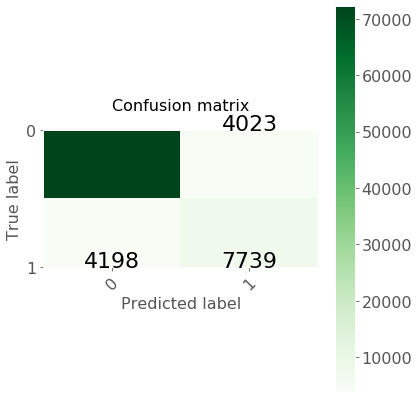

Normalized confusion matrix
[[0.95 0.05]
 [0.35 0.65]]


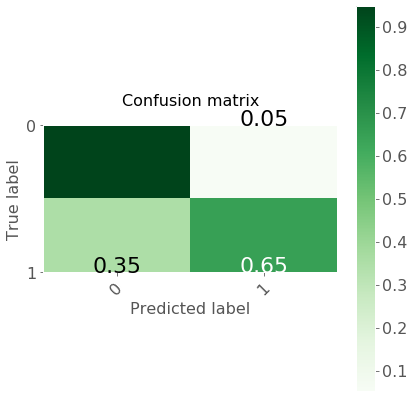

<class 'sklearn.linear_model.logistic.LogisticRegression'> does not have a feature importance chart.


LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=8, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=1,
                   warm_start=False)

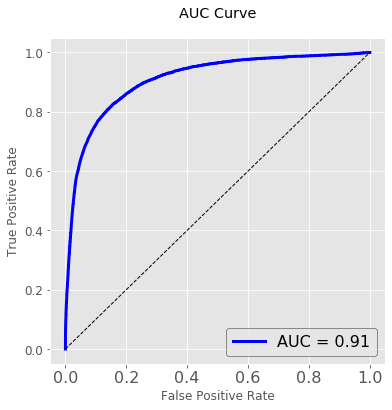

In [93]:
# RandomizedSearchCV - Logistic Regression
# Train, cross-validate (3-folds) and test

c = [0.1, 1, 10, 100]
solver = ['liblinear', 'sag']

lg_params = {'C': c, 
             'verbose': [1],
             'class_weight': ['balanced'],
             'solver': solver,
             'n_jobs': [8]
            }

# lg_func(3, lg_params, 2, X_train, X_test, y_train, y_test)
gen_func('LG', 3, lg_params, 2, X_train, X_test, y_train, y_test)

Model is <class 'sklearn.ensemble.forest.RandomForestClassifier'>


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   35.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   34.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 

Best parameters using f1: {'verbose': 1, 'n_jobs': 8, 'n_estimators': 300, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}

Grid Scores:

Mean is 0.843 std is 0.003 and params are {'verbose': 1, 'n_jobs': 8, 'n_estimators': 300, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}
Mean is 0.825 std is 0.002 and params are {'verbose': 1, 'n_jobs': 8, 'n_estimators': 100, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.6s finished


Threshold is 0.1
Current f1_score is 0.741

Threshold is 0.2
Current f1_score is 0.826

Threshold is 0.3
Current f1_score is 0.834

Threshold is 0.4
Current f1_score is 0.843

Threshold is 0.5
Current f1_score is 0.849

Threshold is 0.6
Current f1_score is 0.841

Threshold is 0.7
Current f1_score is 0.807

Threshold is 0.8
Current f1_score is 0.729

Threshold is 0.9
Current f1_score is 0.419

The best f1_score is 0.849 and the best threshold is 0.5
Train Set Scores
Accuracy score: 0.9996483865479499
f1_score: 0.9987015344232998

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228686
           1       1.00      1.00      1.00     35809

    accuracy                           1.00    264495
   macro avg       1.00      1.00      1.00    264495
weighted avg       1.00      1.00      1.00    264495

[[228637     49]
 [    44  35765]]

Test Set Scores
Accuracy score: 0.9591452487353401
f1_score: 0.848960080509896

              precisio

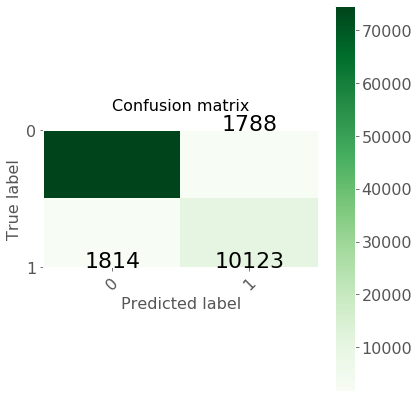

Normalized confusion matrix
[[0.98 0.02]
 [0.15 0.85]]


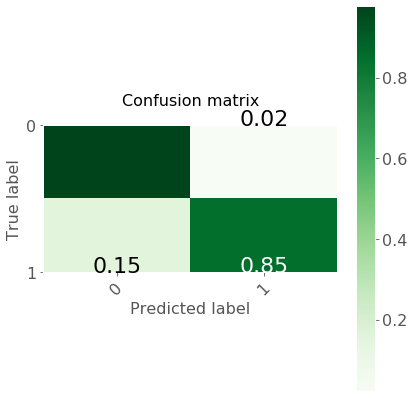

Shape of feature importance vector:  (99,)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=8, oob_score=False,
                       random_state=None, verbose=1, warm_start=False)

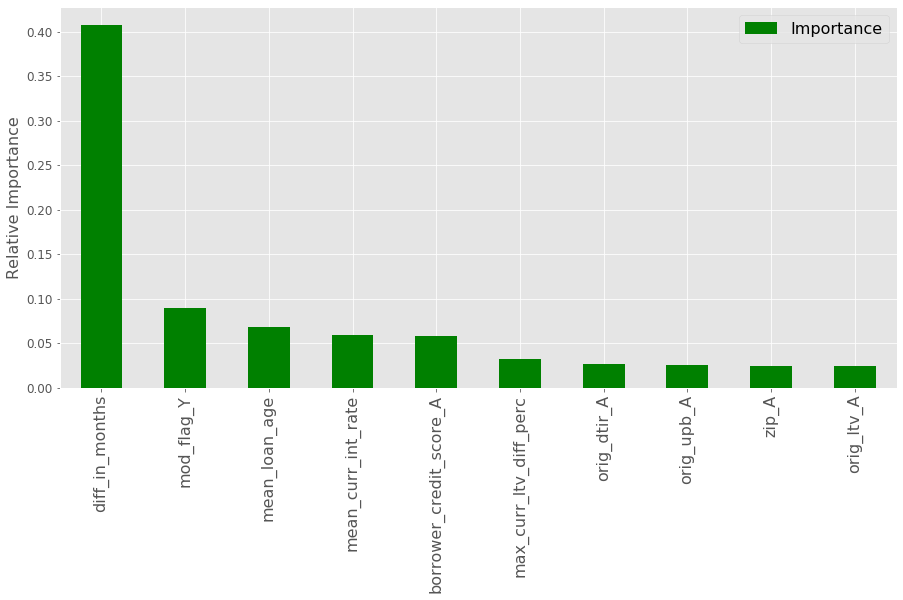

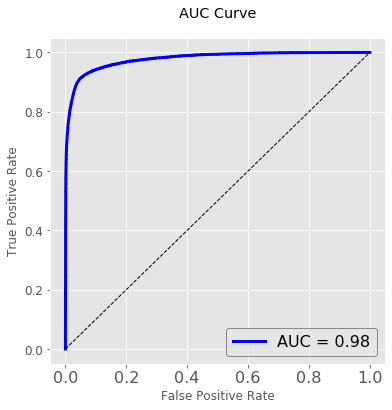

In [94]:
# RandomizedSearchCV - Random Forest
# Train, cross-validate (3-folds) and test

estimators = [100, 200, 300]
max_depth = [10, 20, 30]

rf_params = {'criterion': ['entropy'],
              'n_estimators': estimators,
              'max_depth': max_depth,
              'n_jobs': [8],
              'class_weight': ['balanced'],
              'verbose': [1]
            }

gen_func('RF', 3, rf_params, 2, X_train, X_test, y_train, y_test)

Model is <class 'xgboost.sklearn.XGBClassifier'>
Best parameters using f1: {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 8, 'n_estimators': 200, 'max_depth': 10, 'colsample_bytree': 0.6}

Grid Scores:

Mean is 0.845 std is 0.004 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 8, 'n_estimators': 200, 'max_depth': 10, 'colsample_bytree': 0.6}
Mean is 0.843 std is 0.002 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'n_jobs': 8, 'n_estimators': 200, 'max_depth': 10, 'colsample_bytree': 0.6}
Threshold is 0.1
Current f1_score is 0.803

Threshold is 0.2
Current f1_score is 0.840

Threshold is 0.3
Current f1_score is 0.850

Threshold is 0.4
Current f1_score is 0.855

Threshold is 0.5
Current f1_score is 0.852

Threshold is 0.6
Current f1_score is 0.845

Threshold is 0.7
Current f1_score is 0.830

Threshold is 0.8
Current f1_score is 0.811

Threshold is 0.9
Current f1_score is 0.777

The best f1_score is 0.855

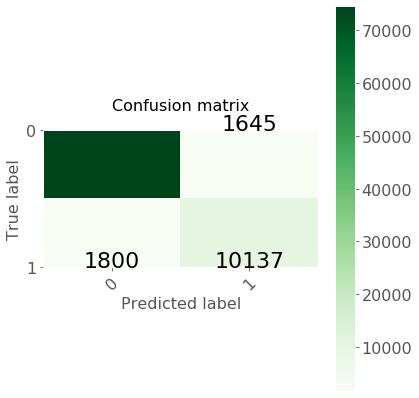

Normalized confusion matrix
[[0.98 0.02]
 [0.15 0.85]]


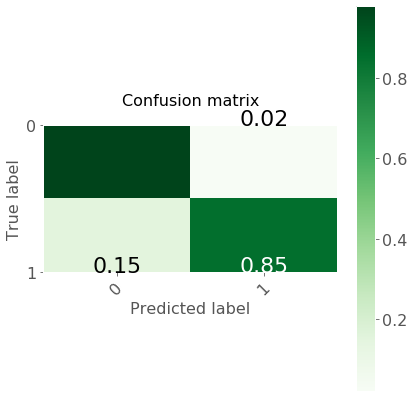

Shape of feature importance vector:  (99,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

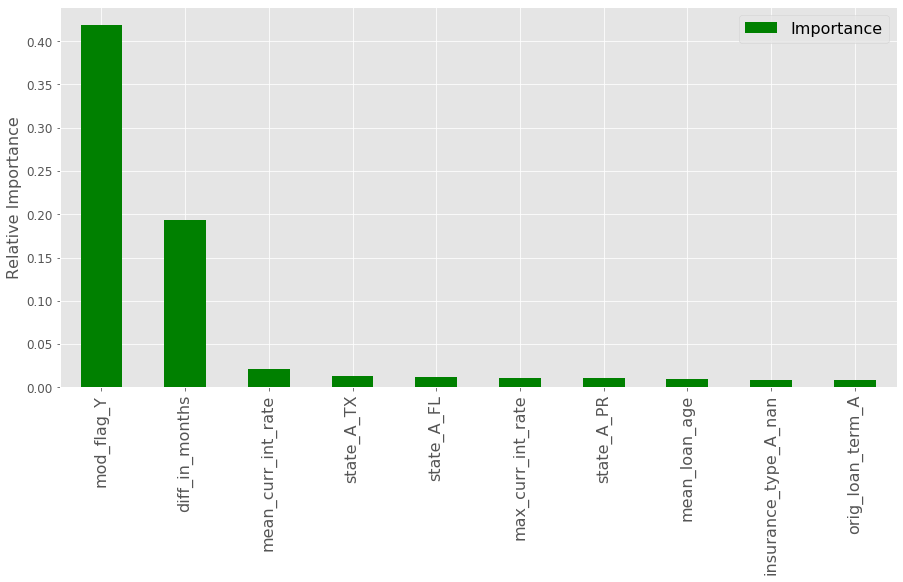

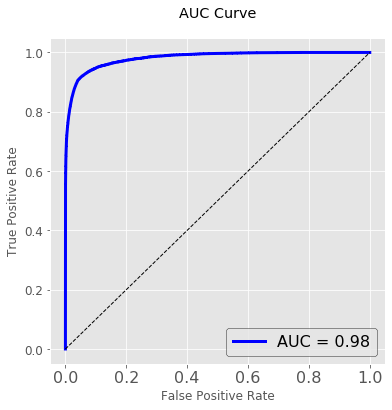

In [95]:
# RandomizedSearchCV - XGB
# Train, cross-validate (3-folds) and test

n_estimators = [100, 200, 300]
max_depth = [10, 20, 30]
colsample_bytree = [0.5, 0.6]
reg_lambda = [0.1, 1]
scale_pos_weight = [1]

xgb_params = {'n_estimators': n_estimators,
              'colsample_bytree': colsample_bytree,
              'n_jobs': [8], 
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'scale_pos_weight': scale_pos_weight, 
              'silent': [False]}

# xgb_func(3, xgb_params, 2, X_train, X_test, y_train, y_test)
gen_func('XGB', 3, xgb_params, 2, X_train, X_test, y_train, y_test)

## SMOTE Over-Sampling

Through our threshold tuning, we see that 0.5 is not always the best threshold to get the highest f1 score, and that threshold tuning is necessary in obtaining an optimum balance between recall and precision.

Next, we will utilize SMOTE over-sampling to see if we can improve the results of our predictive models. 

In [96]:
# if you put SMOTE(ratio={1:800, 2:800}), it will oversample class 1 until 800 and class 2 until 800.
# If you don't specify a class, will take the original amount and aim to match that

print('Original dataset shape {}'.format(Counter(y_train)))

sm = SMOTE(random_state=10)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_smote)))

X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
display(X_train_smote.head())

Original dataset shape Counter({0: 228686, 1: 35809})
Resampled dataset shape Counter({1: 228686, 0: 228686})


,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_U,first_time_Y,purpose_A_P,purpose_A_R,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_P,occupancy_type_A_S,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,state_A_LA,state_A_MA,state_A_MD,state_A_ME,state_A_MI,state_A_MN,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_C,orig_channel_A_R
0,6.500,80000.0,360.0,36.0,1.0,25.0,612.0,1.0,206.0,6.500,6.500,26.500000,10.0,21.656828,0.0,0.0,0.005952,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,6.375,150000.0,180.0,69.0,2.0,49.0,582.0,1.0,601.0,6.375,6.375,7.400000,-2.6,8.841282,0.0,0.0,0.827599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,6.625,258000.0,360.0,80.0,2.0,49.0,701.0,1.0,985.0,6.625,6.625,43.857143,-79.0,40.258354,0.0,0.0,0.014738,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,6.375,375000.0,360.0,69.0,1.0,62.0,635.0,1.0,906.0,6.375,6.375,18.000000,-16.0,0.000000,0.0,0.0,0.340109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,6.250,287000.0,360.0,70.0,1.0,45.0,667.0,1.0,88.0,6.250,6.250,4.500000,0.0,2.698082,0.0,0.0,0.766379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Model is <class 'xgboost.sklearn.XGBClassifier'>
Best parameters using f1: {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 8, 'n_estimators': 100, 'max_depth': 10, 'colsample_bytree': 0.6}

Grid Scores:

Mean is 0.943 std is 0.062 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 8, 'n_estimators': 100, 'max_depth': 20, 'colsample_bytree': 0.6}
Mean is 0.945 std is 0.060 and params are {'silent': False, 'scale_pos_weight': 1, 'reg_lambda': 1, 'n_jobs': 8, 'n_estimators': 100, 'max_depth': 10, 'colsample_bytree': 0.6}
Threshold is 0.1
Current f1_score is 0.791

Threshold is 0.2
Current f1_score is 0.837

Threshold is 0.3
Current f1_score is 0.848

Threshold is 0.4
Current f1_score is 0.853

Threshold is 0.5
Current f1_score is 0.852

Threshold is 0.6
Current f1_score is 0.844

Threshold is 0.7
Current f1_score is 0.830

Threshold is 0.8
Current f1_score is 0.808

Threshold is 0.9
Current f1_score is 0.771

The best f1_score is 0.853 a

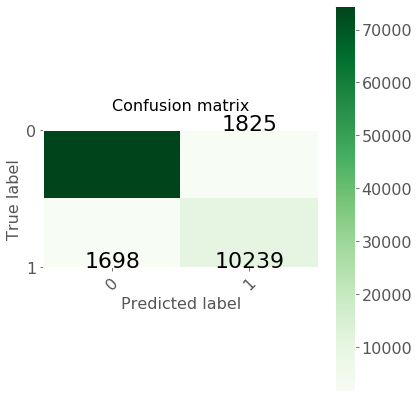

Normalized confusion matrix
[[0.98 0.02]
 [0.14 0.86]]


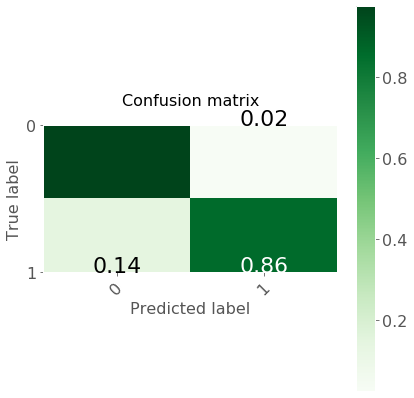

Shape of feature importance vector:  (99,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

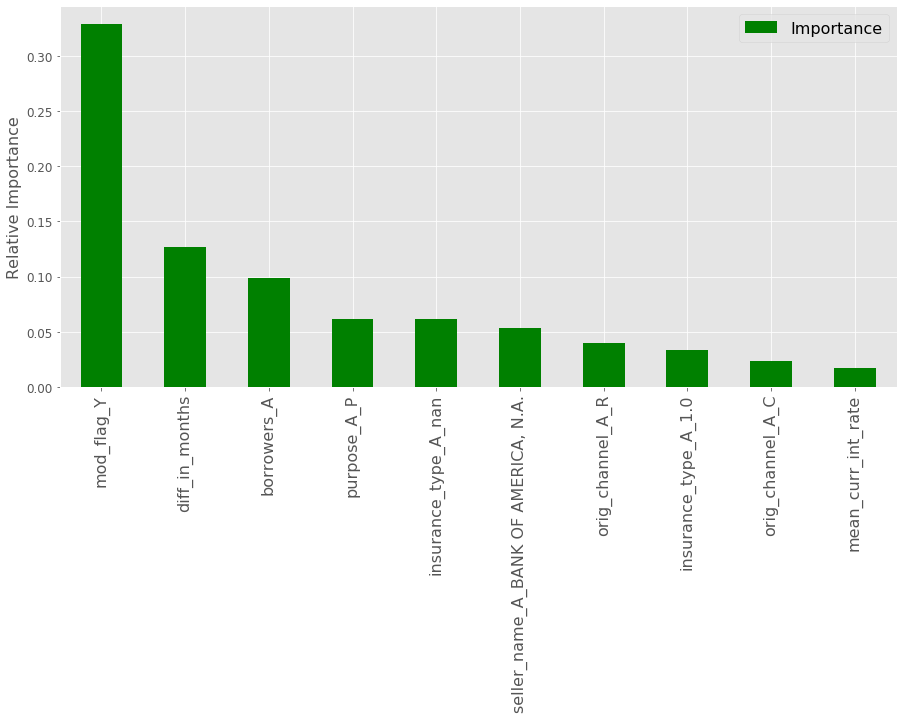

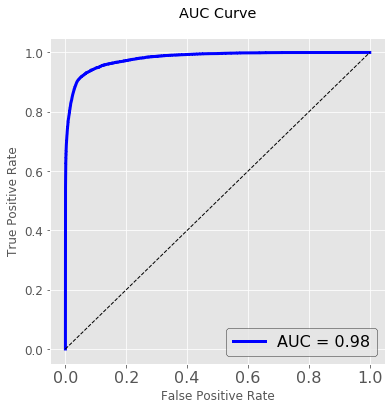

In [97]:
# RandomizedSearchCV - XGB - SMOTE
# Train, cross-validate (3-folds) and test

n_estimators = [100, 200, 300]
max_depth = [10, 20, 30]
colsample_bytree = [0.5, 0.6]
reg_lambda = [0.1, 1]
scale_pos_weight = [1]

xgb_params = {'n_estimators': n_estimators,
              'colsample_bytree': colsample_bytree,
              'n_jobs': [8],
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'scale_pos_weight': scale_pos_weight, 
              'silent': [False]}

gen_func('XGB', 3, xgb_params, 2, X_train_smote, X_test, y_train_smote, y_test)

From the above, it does not appear SMOTE has improved model performance much as the F1 score and ROC AUC has virtually not changed from the non-SMOTE version. 

<h1 align='center'>Feature Dependency Plotting (Top 4)</h1>

With the feature importances from the Random Forest models, we can now plot them to see how they vary with mortgage default rates to get a clearer picture of how each feature varies with the target. 

In [98]:
depen = snapshot_df_concat.copy()
depen.head()

,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,zip_A,mean_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,diff_in_months,max_curr_ltv_diff_perc,mod_flag_Y,max_servicing_activity_indicator,MSA_mapped,first_time_U,first_time_Y,purpose_A_P,purpose_A_R,property_type_A_CP,property_type_A_MH,property_type_A_PU,property_type_A_SF,occupancy_type_A_P,occupancy_type_A_S,state_A_AL,state_A_AR,state_A_AZ,state_A_CA,state_A_CO,state_A_CT,state_A_DC,state_A_DE,state_A_FL,state_A_GA,state_A_GU,state_A_HI,state_A_IA,state_A_ID,state_A_IL,state_A_IN,state_A_KS,state_A_KY,state_A_LA,state_A_MA,state_A_MD,state_A_ME,state_A_MI,state_A_MN,state_A_MO,state_A_MS,state_A_MT,state_A_NC,state_A_ND,state_A_NE,state_A_NH,state_A_NJ,state_A_NM,state_A_NV,state_A_NY,state_A_OH,state_A_OK,state_A_OR,state_A_PA,state_A_PR,state_A_RI,state_A_SC,state_A_SD,state_A_TN,state_A_TX,state_A_UT,state_A_VA,state_A_VI,state_A_VT,state_A_WA,state_A_WI,state_A_WV,state_A_WY,relocation_A_Y,"seller_name_A_BANK OF AMERICA, N.A.","seller_name_A_CHASE HOME FINANCE, LLC","seller_name_A_CITIMORTGAGE, INC.","seller_name_A_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",seller_name_A_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,seller_name_A_FLAGSTAR CAPITAL MARKETS CORPORATION,"seller_name_A_GMAC MORTGAGE, LLC","seller_name_A_HSBC BANK USA, NATIONAL ASSOCIATION","seller_name_A_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",seller_name_A_OTHER,"seller_name_A_PNC BANK, N.A.",seller_name_A_SUNTRUST MORTGAGE INC.,"seller_name_A_WELLS FARGO BANK, N.A.",insurance_type_A_1.0,insurance_type_A_2.0,insurance_type_A_nan,orig_channel_A_C,orig_channel_A_R
0,6.625,343000.0,360,86.0,2.0,27.0,751.0,1,809,6.625000,6.625,4.000000,0,-1.000000,0.000000,0,0,0.018139,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.250,400000.0,360,62.0,2.0,35.0,804.0,1,920,6.250000,6.250,40.500000,0,-0.166667,7.756000,0,0,0.070289,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,6.625,81000.0,360,64.0,1.0,53.0,585.0,1,708,5.750000,6.625,52.846154,1,0.500000,5.439761,1,0,0.024658,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,6.500,119000.0,360,71.0,1.0,35.0,646.0,1,600,6.500000,6.500,44.615385,0,-3.153846,26.292578,0,0,0.827599,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,6.625,205000.0,360,27.0,1.0,54.0,591.0,1,907,5.267857,6.625,50.571429,1,0.666667,6.749617,1,0,0.340109,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [99]:
# Plotting function for comparing features to their default rates

def plotter(binner,palette_choice,binned_feature,feature_label,depen):
    
    feature = re.sub('binned_','',binned_feature)
    depen[binned_feature] = depen[feature].apply(binner)
    display(depen[[feature,binned_feature]].head())
    
    # Set color palette
    if palette_choice == 1:
        palette = ['#db230f', '#db560f', '#e58e02', '#ffe900', '#e1ff00', '#1dff00']              
        sns.set_palette(palette)                     # Red then Green
    elif palette_choice == 2:
        palette = ['#db230f', '#db560f', '#e58e02', '#ffe900', '#e1ff00', '#1dff00']              
        sns.set_palette(list(reversed(palette)))     # Green then Red
    
    # Set style and context for font scaling
    sns.set_style('darkgrid')
    sns.set_context('talk', font_scale=1.6)

    # Set figure and axes objects
    fig, ax = plt.subplots(figsize=(12,6))

    # Calculate defaults vs binned feature
    default_count = (depen[depen['max_loan_stat']==1]
                     .groupby([binned_feature])['max_loan_stat']
                     .count()*100/depen.groupby([binned_feature])['max_loan_stat'].count())

    # Plot data
    sns.barplot(x=default_count.index, y=default_count.values, palette=sns.color_palette(), ax=ax)

    # Set titles
    fig.suptitle('Defaults and '+feature_label)
    ax.set_xlabel(feature_label)
    ax.set_ylabel('Percentage Defaults (%)')

### Compare 'Mean Difference in Months' to Default Rates

,diff_in_months,binned_diff_in_months
0,-1.000000,0 and Below
1,-0.166667,0 and Below
2,0.500000,0 to 1
3,-3.153846,0 and Below
4,0.666667,0 to 1


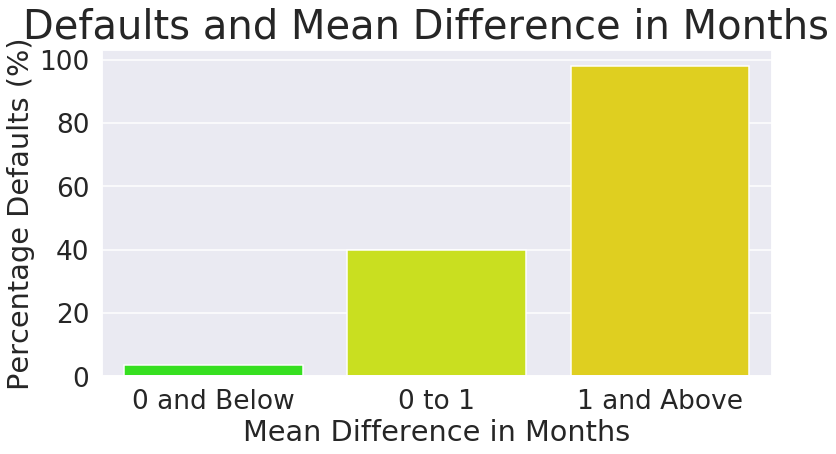

In [100]:
def binner_months(x):
    if 1<x:
        return '1 and Above'
    elif 0<x<=1:
        return '0 to 1'
    else:
        return '0 and Below'
    
plotter(binner_months,2,'binned_diff_in_months','Mean Difference in Months',depen)

We see that having missed payments makes it much more likely that a borrower will go on to actually default. 

### Compare 'Borrower Credit Score' to 'Default Rates'

,borrower_credit_score_A,binned_borrower_credit_score_A
0,751.0,700-800
1,804.0,800 and Above
2,585.0,500-600
3,646.0,600-700
4,591.0,500-600


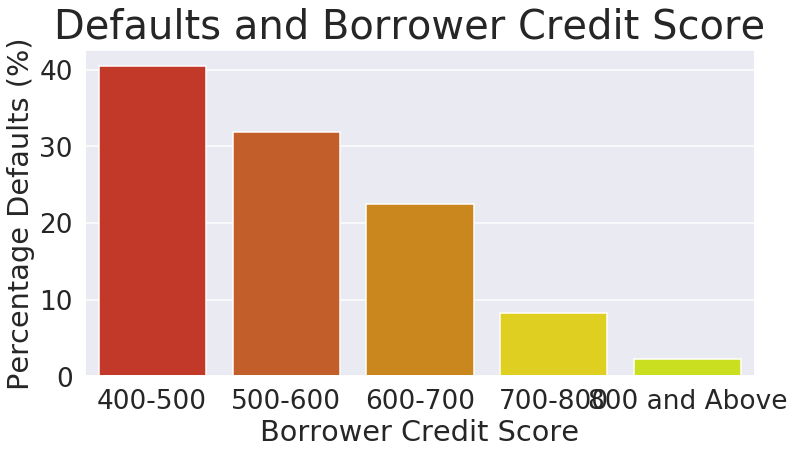

In [101]:
def binner_borrower_credit_score_A(x):
    if 400 <= x < 500:
        return '400-500'
    elif 500 <= x <600:
        return '500-600'
    elif 600 <= x < 700:
        return '600-700'
    elif 700 <= x < 800:
        return '700-800'
    elif 800 <= x:
        return '800 and Above'

plotter(binner_borrower_credit_score_A,1,'binned_borrower_credit_score_A','Borrower Credit Score',depen)

Low credit scores carry much higher risks as seen from the graph above. Default rates are almost 60% for those with credit scores between 400-500. 

### Compare 'Mean Loan Age' to 'Default Rates'

,mean_loan_age,binned_mean_loan_age
0,4.000000,0 to 20
1,40.500000,40 to 60
2,52.846154,40 to 60
3,44.615385,40 to 60
4,50.571429,40 to 60


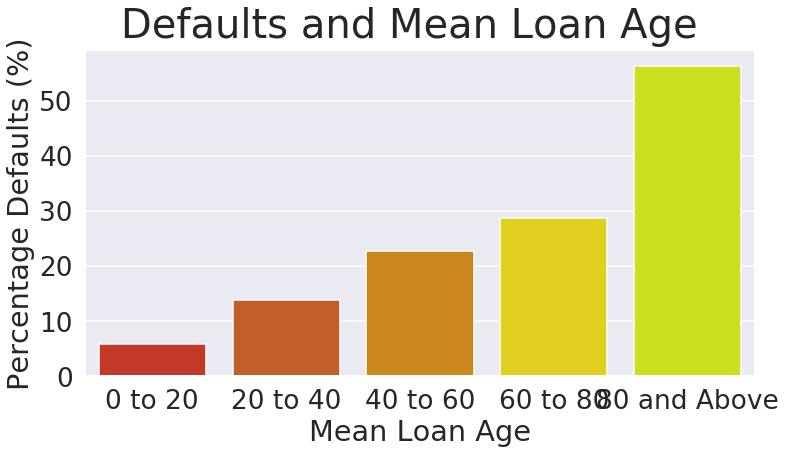

In [102]:
def binner_mean_loan_age(x):
    if 80<x:
        return '80 and Above'
    elif 60<x<=80:
        return '60 to 80'
    elif 40<x<=60:
        return '40 to 60'
    elif 20<x<=40:
        return '20 to 40'
    else:
        return '0 to 20'

plotter(binner_mean_loan_age,1,'binned_mean_loan_age','Mean Loan Age',depen)

Loans that just started out have a higher default rate compared to loans that have been going on for a while. 

### Compare 'Max LTV Percentage Difference' to 'Default Rates'

,max_curr_ltv_diff_perc,binned_max_curr_ltv_diff_perc
0,0.000000,0 to 10
1,7.756000,0 to 10
2,5.439761,0 to 10
3,26.292578,20 to 30
4,6.749617,0 to 10


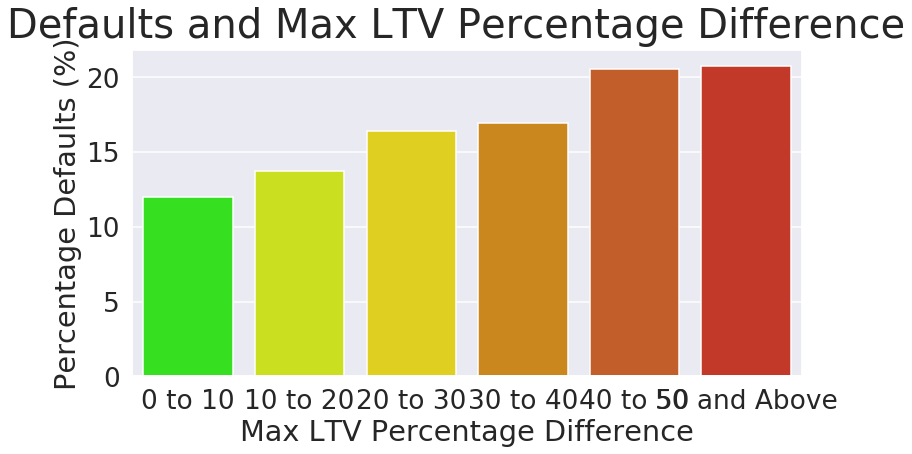

In [103]:
def binner_max_curr_ltv_diff_perc(x):
    if 50<x:
        return '50 and Above'
    elif 40<x<=50:
        return '40 to 50'
    elif 30<x<=40:
        return '30 to 40'
    elif 20<x<=30:
        return '20 to 30'
    elif 10<x<=20:
        return '10 to 20'
    else:
        return '0 to 10'

plotter(binner_max_curr_ltv_diff_perc,2,'binned_max_curr_ltv_diff_perc','Max LTV Percentage Difference',depen)

As expected during the creation of this custom feature, mortgages that have experienced severe drops in their house prices have defaulted at higher rates as their LTVs soared from the crashing house prices. 